# Teaching Emotion Through Feature Matching Using Convolutional Neural Networks 



#### FROM TRAVIS: Use one of the small models and see how that does
* Make training time → VGG16 or 19 with no weights (raw model with random weights) 
* Try to train and see how it goes 
* Time 
* Performance 
* Then try to do the same thing with ResNet 50 or V2 (107 layers) → another model that is a little bit bigger 
* Do this all from scratch 
* If this doesn't work ⇒ try to do fine tuning and initialize with imageNET that has more faces and train on top of that 
https://keras.io/api/applications/


## Trial #1: VGG16 Model 

Note: Testing first without weights and then with weigths 

In [ ]:
# Core Dependencies (for all models)
import os
import numpy as np
import matplotlib.pyplot as plt

# Deep Learning Dependencies
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Custom Dependencies (for VGG16 Model) 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout

## Trial #1: VGG16 w/ Random Weights

### Load and Pre-process FER2013 Dataset

In [3]:
# Define image parameters and paths
img_size = (48, 48)
batch_size = 64
dataset_test = 'FER2013/test'
dataset_train = 'FER2013/train'

### Create Data Generators 


In [ ]:
# Train/Validation split from folder 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # Use part of training as validation
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
# Create the generators
train_generator = train_datagen.flow_from_directory(
    'FER2013/train',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Training subset
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'FER2013/train',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Validation subset
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    'FER2013/test',
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Define the Model

In [42]:
# Define VGG16 model
def build_vgg16(input_shape=(48, 48, 1), num_classes=7):
    base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

vgg16_model = build_vgg16()
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,103 (56.38 MB)

 Trainable params: 14,780,103 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training (Random Weights)

In [44]:
# Train the model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history = vgg16_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)



Epoch 1/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 546s 1s/step - accuracy: 0.2500 - loss: 1.8182 - val_accuracy: 0.2515 - val_loss: 1.8105 - learning_rate: 0.0010
Epoch 2/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.2521 - loss: 1.8136 - val_accuracy: 0.2515 - val_loss: 1.8098 - learning_rate: 0.0010
Epoch 3/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.2496 - loss: 1.8125 - val_accuracy: 0.2515 - val_loss: 1.8096 - learning_rate: 0.0010
Epoch 4/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.2499 - loss: 1.8132 - val_accuracy: 0.2515 - val_loss: 1.8095 - learning_rate: 0.0010
Epoch 5/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.2505 - loss: 1.8103 - val_accuracy: 0.2515 - val_loss: 1.8096 - learning_rate: 0.0010
Epoch 6/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.2541 - loss: 1.8079 - val_accuracy: 0.2515 - val_loss: 1.8112 - learning_rate: 0.0010
Epoch 7/30
382/382 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.2517 - loss: 1.

### Evaluate on Test Set 

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = vgg16_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


112/112 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.2223 - loss: 1.8760
Test Loss: 1.8127, Test Accuracy: 0.2475


Question: Was this training model successful? 

Answer: No, this model was not successful. While it was able to complete training without errors, the resulting test accuracy of 25% is significantly below the threshold for success in a 7-class classification task. Random guessing would yield approximately 14.3% accuracy (1 in 7), so although the model is performing slightly better than chance, it is not making consistently correct predictions. Furthermore, ideal loss after training should drop below 1.0, and ideally to < 0.5 for good accuracy. We recieved a 1.81 test loss.
* Accuracy: 25%
* Loss: 181%

### Plot Training History 

This is intial plot training history to show failure with using a model without any predefined weights.

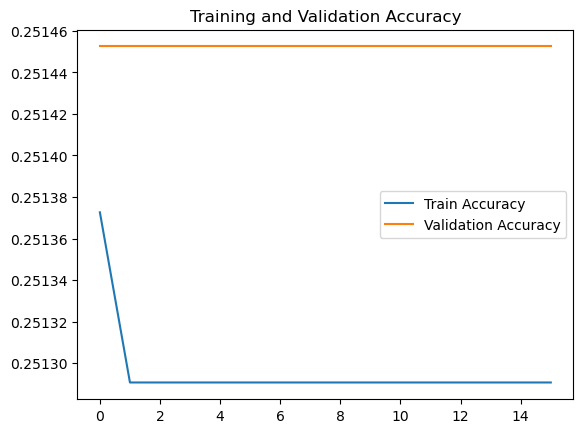

In [46]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

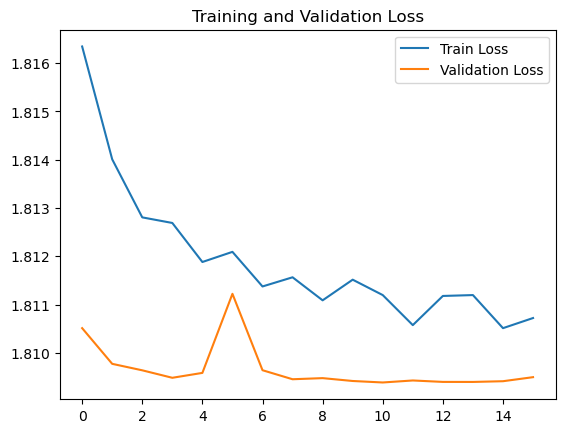

In [47]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Trial #2: VGG16 with RGB Conversion 

In [6]:
# Define image parameters and paths (adding rgb)
img_size = (48, 48)
batch_size = 64
rgb_size = (48, 48, 3)  # 3-channel input for VGG16 with ImageNet 

### Re-define the Data Generators (w/ RGB Conversion)

In [60]:
def to_rgb(img):
    return np.repeat(img, 3, axis=2)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_train,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    dataset_test,
    target_size=img_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Load VGG16 Base w/ IMAGENET Weights

In [50]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=rgb_size)

# Freeze all base layers
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [51]:
# Add custom classifier head 
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)

### Create Model (Test 2)

In [52]:
# Create the model
model_2 = Model(inputs=base_model.input, outputs=output)

model_2.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         1,79

 Total params: 15,110,471 (57.64 MB)

 Trainable params: 395,783 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [55]:
# Train the model w/ ImageNet Weights 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

history = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 110s 288ms/step - accuracy: 0.2169 - loss: 1.8890 - val_accuracy: 0.3140 - val_loss: 1.7165 - learning_rate: 1.0000e-04
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 118s 309ms/step - accuracy: 0.2942 - loss: 1.7380 - val_accuracy: 0.3444 - val_loss: 1.6828 - learning_rate: 1.0000e-04
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 121s 316ms/step - accuracy: 0.3219 - loss: 1.6999 - val_accuracy: 0.3500 - val_loss: 1.6594 - learning_rate: 1.0000e-04
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 123s 322ms/step - accuracy: 0.3232 - loss: 1.6890 - val_accuracy: 0.3474 - val_loss: 1.6496 - learning_rate: 1.0000e-04
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 123s 322ms/step - accuracy: 0.3360 - loss: 1.6642 - val_accuracy: 0.3477 - val_loss: 1.6447 - learning_rate: 1.0000e-04
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.3387 - loss: 1.6511 - val_accuracy: 0.3591 - val_loss: 1.6292 - learning_rate: 1.0000e-04
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 646

### Evaluate the Model 

In [61]:
# Evaluate the model (test #2)
test_loss, test_accuracy = model_2.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

/opt/anaconda3/envs/env1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.3391 - loss: 1.6401
Test Loss: 1.4901, Test Accuracy: 0.4281


**Question: Was this training model successful?**

**Answer:** No, this training model was not successful. While it showed some learning progress, the overall performance fell short of expectations for a 7-class emotion classification task. The model used was VGG16 with ImageNet pretrained weights, which helped improve the accuracy to approximately 43%, but this is still well below an acceptable benchmark for real-world emotion recognition (typically 70–80%+). The loss remained high (~1.49 or 149%), indicating that the model’s confidence in its predictions was weak and often incorrect. Also, VGG16, even with ImageNet, is too shallow for nuanced emotions like fear vs surprise. It performs well on general image classification, but it struggles with similar emotions. Lastly, the model’s base layers were likely not fine-tuned deeply enough to adapt to facial features rather than general object recognition.
* Accuracy: 43% 
* Loss: almost 149% 